# Multi-Model and Network Inference Based on Ensemble Estimates: Avoiding  the Madness of Crowds

###   Supplementary Material


This notebook contains all the information needed to reproduce the results and figures  in the  main manuscript. It also allows the exploration of other scenarios.

Running the code requires  a number of packages to be installed as part of the Julia environment:

- Distributions
- StatsPlots
- QuadGK
- Special Functions
- GSL

Some additional packages can be used to improve plotting, in particular

- LaTeXStrings


In [1]:
# Load the required packages
using Plots
using Distributions
using StatsPlots
using QuadGK
using LaTeXStrings
using SpecialFunctions
using GSL

using LaTeXStrings

using Pkg
ENV["GRDIR"]=""
Pkg.build("GR")

  Building GR → `~/.julia/packages/GR/ZI5OE/deps/build.log`


false

##  The effective model space

In [2]:
# Here we define functions that calculate the  distributions for model weights, assuming that
# costs follow a Gamma or Log-normal distrubution; while the latter is not used in the paper it
# represents a useful distribution for many practical applications


function fGy(ap,bp,y) # Gamma distributed costs
    ((-log(y))^(ap-1.0)*y^(1/bp))/(y*gamma(ap)*(bp^ap))
    end;

function fLy(mp,sp,y) # Log-normal distributed costs
    exp(-((log(-log(y))-mp)^2)/(2*sp^2))/(y*(-log(y))*sqrt(2*pi*sp^2))
    end;

# Auxiallary functions to aid plotting for default parameters
function fGy1(y)
    fGy(1.,1.,y)
    end;

function fGy2(y)
    fGy(2.0,2.0,y)
    end;

function fGy3(y)
    fGy(1.5,1.0,y)
    end;

function fGy4(y)
    fGy(1.5,2.0,y)
    end;

function  fLy1(y)
    fLy(1.00,1.0,y)
    end;

function  fLy2(y)
    fLy(2.0,2.0,y)
    end;

In [3]:
#  Here we define probability distributions
probG1=Gamma(1.0,1.0);
probG2=Gamma(2.0,2.0);
probG3=Gamma(1.5,1.0);
probG4=Gamma(1.5,2.0);
probL1=LogNormal(.0,1.0);
probL2=LogNormal(2.0,2.0);

# define x-range for plotting
xr=0.0:0.1:10.0;
xry=0.01:0.0001:1;


In [4]:
testG3=rand(probG3,10000);
tyG3=exp.(-testG3);
testG1=rand(probG1,10000);
tyG1=exp.(-testG1);
testG2=rand(probG2,10000);
tyG2=exp.(-testG2);
testG4=rand(probG4,10000);
tyG4=exp.(-testG4);

function fGy1cost(y)
    -log(y)*fGy(1.,1.0,y)
    end;
function fGy2cost(y)
    -log(y)*fGy(2.,2.0,y)
    end;
function fGy3cost(y)
    -log(y)*fGy(1.5,1.0,y)
    end;
function fGy4cost(y)
    -log(y)*fGy(1.5,2.0,y)
    end;
yv1=[]
yv2=[]
yv3=[]
yv4=[]
for x in 0.1:0.1:0.9
    push!(yv1,quadgk(fGy1cost,x,1,order=18,rtol=1e-8)[1])
    push!(yv2,quadgk(fGy2cost,x,1,order=18,rtol=1e-8)[1])
    push!(yv3,quadgk(fGy3cost,x,1,order=18,rtol=1e-8)[1])
    push!(yv4,quadgk(fGy4cost,x,1,order=18,rtol=1e-8)[1])
end

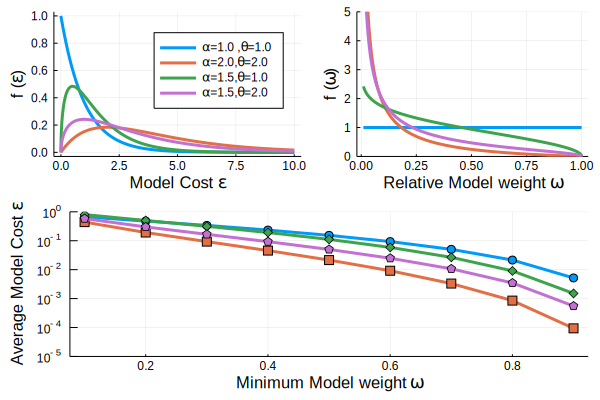

In [5]:
#  This is the code required to reproduce the results in Figure 2 in the manuscript
xr=0:0.01:10.0
xry=0.01:0.0001:1

l=@layout[a b;c]
p1=plot(xr,[pdf.(probG1,xr),pdf.(probG2,xr),pdf.(probG3,xr),pdf.(probG4,xr)],xaxis=("Model Cost \\epsilon"),yaxis=("f (\\epsilon)",0:0.2:1), w=3,label=(["\\alpha=1.0 ,\\theta=1.0"  "\\alpha=2.0,\\theta=2.0"  "\\alpha=1.5,\\theta=1.0" "\\alpha=1.5,\\theta=2.0"]))
p2=plot(xry,[fGy1,fGy2,fGy3,fGy4],legend=false, xaxis=("Relative Model weight \\omega"),yaxis=("f (\\omega)",(0,5.0)), w=3,label=(["\\alpha=1.0 ,\\theta=1.0"  "\\alpha=2.0,\\theta=2.0"  "\\alpha=1.5,\\theta=1.0" "\\alpha=1.5,\\theta=2.0"]))
p3=plot(0.1:0.1:0.9,yv1)
p3=plot(0.1:0.1:0.9,[yv1,yv2,yv3,yv4],legend=false,markershape=[:circle :rect :diamond :pentagon],xaxis=("Minimum Model weight \\omega"),yaxis=(:log,(0.00001,1.0),"Average Model Cost \\epsilon"), w=3,label=(["\\alpha=1.0 ,\\theta=1.0"  "\\alpha=2.0,\\theta=2.0"  "\\alpha=1.5,\\theta=1.0" "\\alpha=1.5,\\theta=2.0"]))
qpcostplot=plot(p1,p2,p3,layout=l)

In [6]:
# This function sets out the inequality required to evauate when characteristics of nuisance 
# models 
function ieqfunc(ω,ν,ρ=0.01,η=0.01) 
    ω*ρ*exp(-η)/(ν*(1-exp(-ω)))
end

ieqfunc (generic function with 3 methods)

In [8]:
# Set up characteristics for 
yvals=0.1:0.01:0.9;
xvals=1:0.1:100;
case1(x,y) = begin
    if ieqfunc(x,y,0.01,0.01)<1
        return 0.0
    else
        return 1.0
        end
end
case2(x,y) = begin
    if ieqfunc(x,y,0.1,0.01)<1
        return 0.0
    else
        return 1.0
     end
            end;

In [9]:
l1=@layout[a;b]
p2=contour(xvals,yvals,case2,fill=(true,cgrad([:black,:white])),title=L"\nu_1 =0.1",legend=false,xaxis=(L"\epsilon_2",font(11)),yaxis=(L"\nu_2",font(11)))
p1=contour(xvals,yvals,case1,fill=(true,cgrad([:black,:white])),title=L"\nu_1 =0.01",legend=false,xaxis=(L"\epsilon_2",font(11)),yaxis=(L"\nu_2",font(11)))
inequplot=plot(p1,p2,layout=l1 )

┌ Warning: GR: filled contour only supported with black contour lines
└ @ Plots /Users/michael/.julia/packages/Plots/Iuc9S/src/backends/gr.jl:1307
┌ Warning: GR: filled contour only supported with black contour lines
└ @ Plots /Users/michael/.julia/packages/Plots/Iuc9S/src/backends/gr.jl:1307


# Network Inference
Here we start by considering ensembles of statistically identical estimators with false negative rate $t$ and false positive rate $s$. From this we can obtain estimates for the false and true positive rates of the ensemble estimators.

In [10]:
function ensembletruepos(t,κ,k)
    res=0.0
    for i in κ:k
        res+= binomial(k,i)*((1.0-t)^i)*t^(k-i)
    end
    return res
end

function ensemblefalsepos(s,κ,k)
    res =0.0
    for i in κ:k
        res+=binomial(k,i)*s^i*(1.0-s)^(k-i)
    end
    return res
    end;

In [11]:
pbinom_true_pos_10=zeros(6)
for k in 5:10
    pbinom_true_pos_10[k-4]=ensembletruepos(0.1,k,10)
end

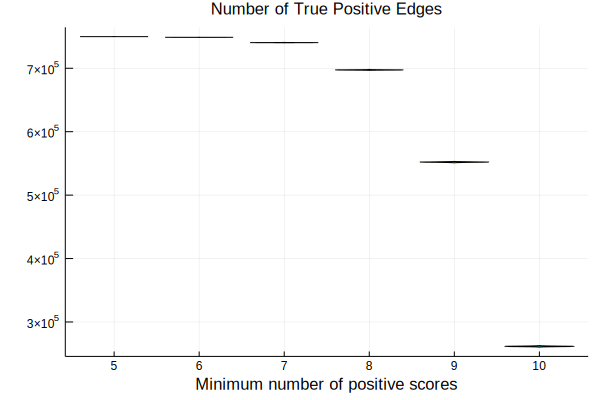

In [12]:
# Calculate the number of true positive edges (assuming that the human network comprises 750,000 interactions)
q=Binomial.(750000,pbinom_true_pos_10)

z1=rand.(q,1000);
vz1=violin(z1,legend=false,xlabel="Minimum number of positive scores",title="Number of True Positive Edges",xticks=(1:1:6,["5","6","7","8","9","10"]),titlefontsize=(11))

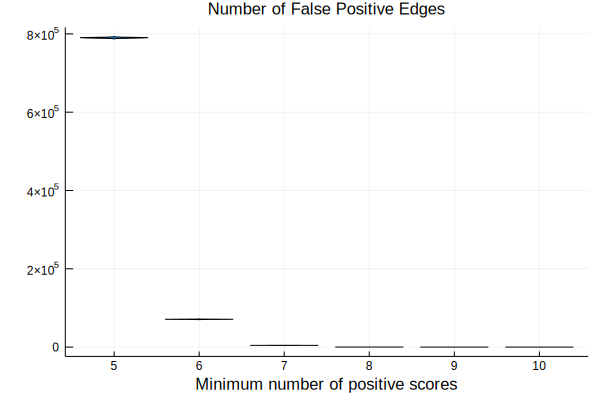

In [14]:
# Calculate the number of false positive edges (assuming that the human network comprises 750,000 interactions among 22,000 nodes)

pbinom_false_pos_10=zeros(6)
for k in 5:10
    pbinom_false_pos_10[k-4]=ensemblefalsepos(0.1,k,10)
end
NNtotal=22000*22000-750000
qf=Binomial.(NNtotal,pbinom_false_pos_10)
z2=rand.(qf,1000);
vz2=violin(z2,legend=false,titlefontsize=(11),xlabel="Minimum number of positive scores",title="Number of False Positive Edges",xticks=(1:1:6,["5","6","7","8","9","10"]))

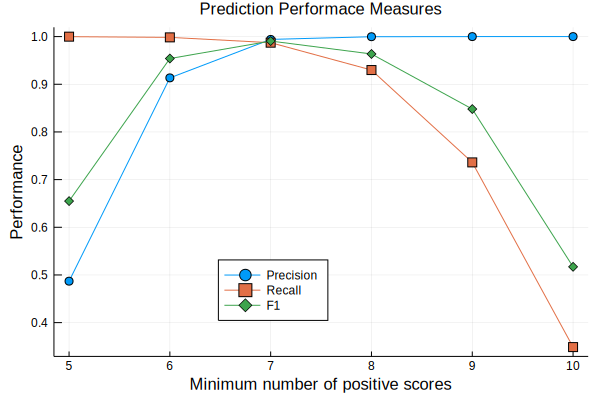

In [15]:
FP10= NNtotal*pbinom_false_pos_10;
TN10=NNtotal.-FP10;
TP10=750000*pbinom_true_pos_10;
FN10=750000 .-TP10;
precision=TP10./(TP10+FP10);
recall=TP10./(TP10+FN10);
F1stat=zeros(6)
for i in 1:6
    F1stat[i]=2.0*precision[i]*recall[i]/(recall[i]+precision[i])
end
performance=plot(5:1:10,[precision,recall,F1stat],yaxis=("Performance"),markershape=[:circle :rect :diamond ],xlabel="Minimum number of positive scores",title="Prediction Performace Measures",titlefontsize=(11),xticks=(5:10,["5","6","7","8","9","10"]),legend=:bottom,label=(["Precision","Recall","F1"]))

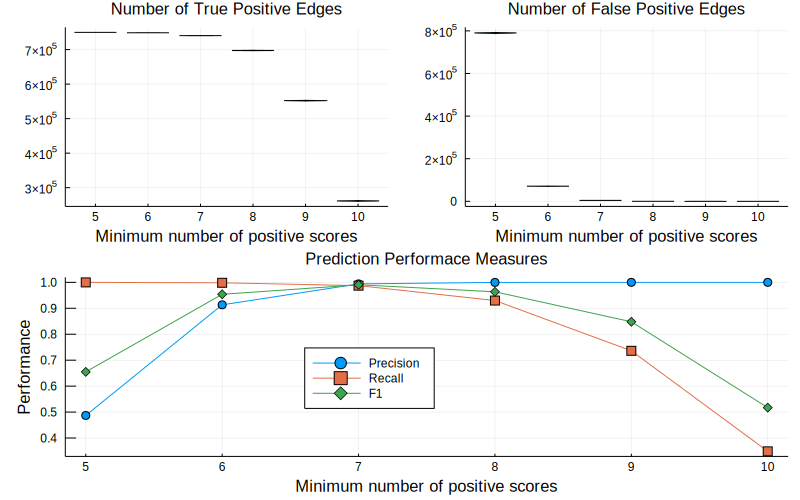

In [16]:
l=@layout[a b;c]
performanceplot=plot(vz1,vz2,performance,layout=l,size=(800,500))

## Precision and Recall as a function of  Ensemble Averages

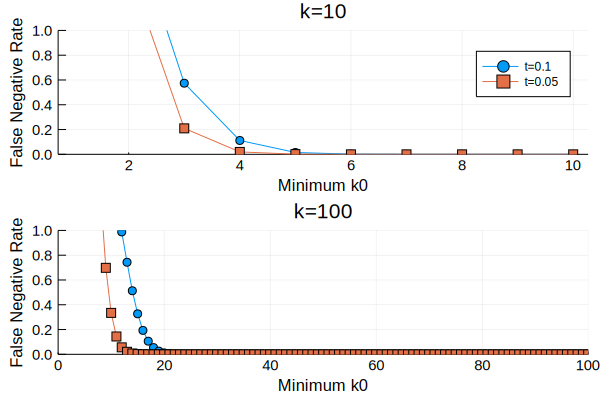

In [20]:
function lowbound(k,p,k0)
    return binomial(BigInt(k),BigInt(k0))*p^(k0-1)*(1-p)^(k-k0)
end
padj01=zeros(10)
padj005=zeros(10)
for i in 1:10 
    padj01[i]=lowbound(10,0.1,i)
    padj005[i]=lowbound(10,0.05,i)
end
seqplot=plot(1:10,[padj01,padj005],label=["t=0.1","t=0.05"],title="k=10",xlabel="Minimum k0",ylim=(0,1),ylabel="False Negative Rate",xtickfont=font(10),markershape=[:circle :rect ],ytickfont=font(10));
function lowboundexact(k,p,k0)
    return binomial(k,k0)*p^(k0-1)*(1-p)^(k-k0)*sf_hyperg_2F1(1,k0-k,k0+1,-p/(1.0-p))
end

padj01=zeros(10)
padj005=zeros(10)
for i in 1:10 
    padj01[i]=lowboundexact(10,0.1,i)
    padj005[i]=lowboundexact(10,0.05,i)
end

pad2j01=zeros(100)
pad2j005=zeros(100)
for i in 1:100 
    pad2j01[i]=lowbound(100,0.1,i)
    pad2j005[i]=lowbound(100,0.05,i)
end
seqplot2=plot(8:100,[pad2j01[8:100],pad2j005[8:100]],title="k=100",label=["t=0.1","t=0.05"],legend=false,xlabel="Minimum k0",xlim=(0,100),ylim=(0,1),ylabel="False Negative Rate",xtickfont=font(10),markershape=[:circle :rect ],ytickfont=font(10))

l1=@layout[a;b]
fnplot=plot(seqplot,seqplot2,layout=l1)

# Heterogenous Ensembles of Network Inference Methods
We consider two classes of estimators, *useful* and *useless* characterised by false negative and false positive rates $t_1, t_2$  and $s_1$ and $s_2$, respectively. 

The fractions of good and bad estimators are $\kappa^{(1)}=v_1k$ and $\kappa^{(2)}=v_2k=(1-v_1)k$. 

In [21]:
    
function ensembletruepos(t1,t2,κ,k1,k)
    res=0.0
    k2= k-k1
    for i in 0:k1
        for j in 0:k2
            if i+j>= κ
                res+=binomial(k1,i)*((1.0-t1)^i)*t1^(k1-i)*binomial(k2,j)*((1.0-t2)^j)*t2^(k2-j)
            end
        end
    end
    return res
end

function ensemblefalsepos(s1,s2,κ,k1,k)
    res=0.0
    k2= k-k1
    for i in 0:k1
        for j in 0:k2
            if i+j>= κ
                res+=binomial(k1,i)*s1^i*((1.0-s1)^(k1-i))*binomial(k2,j)*s2^j*((1.0-s2)^(k2-j))
            end
        end
    end
    return res
    end;

    



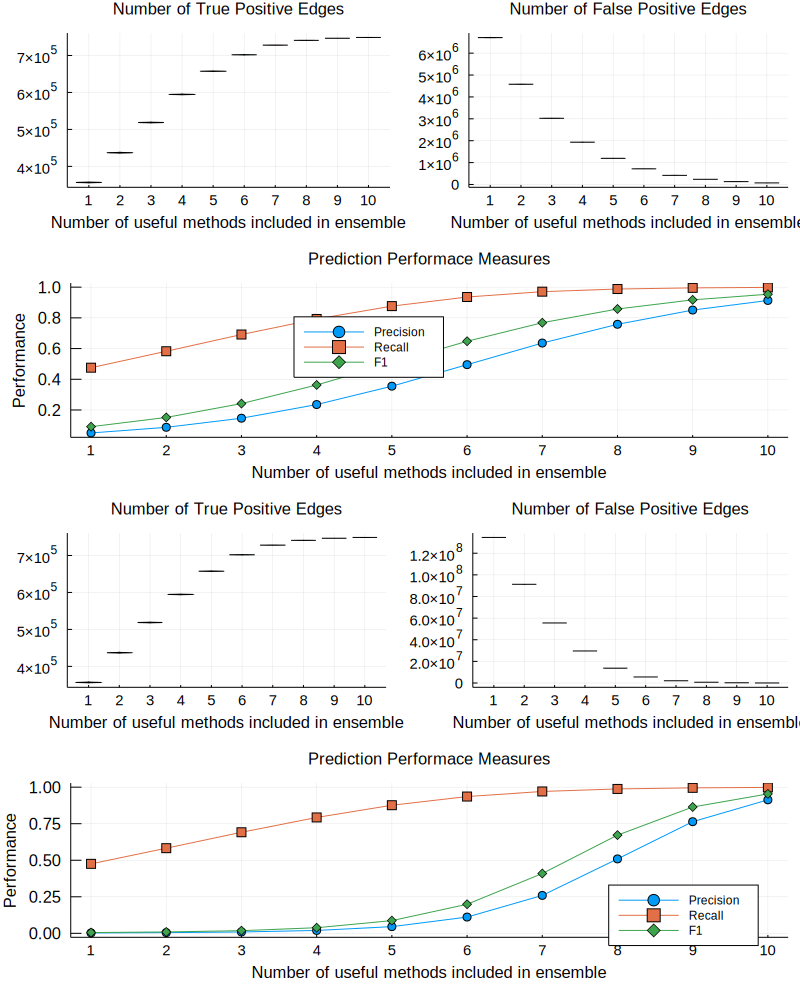

In [37]:

pbinom_true_het_pos_10t2_05=zeros(10)
pbinom_true_het_pos_10t2_025=zeros(10)
pbinom_false_het_pos_10t2_05=zeros(10)
pbinom_false_het_pos_10t2_025=zeros(10)

for k1 in 1:10
    pbinom_false_het_pos_10t2_05[k1]=ensemblefalsepos(0.1,0.5,6,k1,10)
    pbinom_false_het_pos_10t2_025[k1]=ensemblefalsepos(0.1,0.25,6,k1,10)
    pbinom_true_het_pos_10t2_05[k1]=ensembletruepos(0.1,0.5,6,k1,10)
    pbinom_true_het_pos_10t2_025[k1]=ensembletruepos(0.1,0.5,6,k1,10)
end

q10t2025=Binomial.(750000,pbinom_true_het_pos_10t2_025)
q10t205=Binomial.(750000,pbinom_true_het_pos_10t2_05)

z1_10t2025=rand.(q10t2025,1000);
z1_10t205=rand.(q10t205,1000);


vz1t20025=violin(z1_10t2025,legend=false,xlabel="Number of useful methods included in ensemble",title="Number of True Positive Edges",xticks=(1:1:10,["1","2","3","4","5","6","7","8","9","10"]),titlefontsize=(11),xtickfont=font(10),ytickfont=font(10))
vz1t2005=violin(z1_10t205,legend=false,xlabel="Number of useful methods included in ensemble",title="Number of True Positive Edges",xticks=(1:1:10,["1","2","3","4","5","6","7","8","9","10"]),titlefontsize=(11),xtickfont=font(10),ytickfont=font(10));


NNtotal=22000*22000-750000
q10s2025=Binomial.(NNtotal,pbinom_false_het_pos_10t2_025)
q10s205=Binomial.(NNtotal,pbinom_false_het_pos_10t2_05)

z2_10s2025=rand.(q10s2025,1000);
z2_10s205=rand.(q10s205,1000);

vz2s2005=violin(z2_10s205,legend=false,titlefontsize=(11),xlabel="Number of useful methods included in ensemble",title="Number of False Positive Edges",xticks=(1:1:10,["1","2","3","4","5","6","7","8","9","10"]),xtickfont=font(10),ytickfont=font(10))
vz2s20025=violin(z2_10s2025,legend=false,titlefontsize=(11),xlabel="Number of useful methods included in ensemble",title="Number of False Positive Edges",xticks=(1:1:10,["1","2","3","4","5","6","7","8","9","10"]),xtickfont=font(10),ytickfont=font(10))

FP10H025= NNtotal*pbinom_false_het_pos_10t2_025;
TN10H025=NNtotal.-FP10H025;
TP10H025=750000*pbinom_true_het_pos_10t2_025
FN10H025=750000 .-TP10H025
precisionH025=TP10H025./(TP10H025+FP10H025)
recallH025=TP10H025./(TP10H025+FN10H025)

F1statH025=zeros(10)
for i in 1:10
    F1statH025[i]=2.0*precisionH025[i]*recallH025[i]/(recallH025[i]+precisionH025[i])
end

performanceH025=plot(1:1:10,[precisionH025,recallH025,F1statH025],yaxis=("Performance",font(11,"National")),markershape=[:circle :rect :diamond ],xlabel="Number of useful methods included in ensemble",title="Prediction Performace Measures",titlefontsize=(11),xticks=(1:10,["1","2","3","4","5","6","7","8","9","10"]),legend=:bottom,label=(["Precision","Recall","F1"]),xtickfont=font(10),ytickfont=font(10));

FP10H05= NNtotal*pbinom_false_het_pos_10t2_05;
TN10H05=NNtotal.-FP10H05;
TP10H05=750000*pbinom_true_het_pos_10t2_05
FN10H05=750000 .-TP10H05
precisionH05=TP10H05./(TP10H05+FP10H05)
recallH05=TP10H05./(TP10H05+FN10H05)

F1statH05=zeros(10)
for i in 1:10
    F1statH05[i]=2.0*precisionH05[i]*recallH05[i]/(recallH05[i]+precisionH05[i])
end

performanceH05=plot(1:1:10,[precisionH05,recallH05,F1statH05],yaxis=("Performance",font(11,"National")),markershape=[:circle :rect :diamond ],xlabel="Number of useful methods included in ensemble",title="Prediction Performace Measures",titlefontsize=(11),xticks=(1:10,["1","2","3","4","5","6","7","8","9","10"]),legend=:right,label=(["Precision","Recall","F1"]),xtickfont=font(10),ytickfont=font(10));

l=@layout[a b;c;d e; f]
performanceplotH=plot(vz1t20025,vz2s20025,performanceH025,vz1t2005,vz2s2005,performanceH05,size=(800,1000),layout=l)
